In [1]:
cd(expanduser("/project/GHIST-2025/secondary-contact"))
Base.init_active_project()
pwd(), Base.active_project(), gethostname()

("/project/GHIST-2025/secondary-contact", "/project/GHIST-2025/secondary-contact/Project.toml", "folsomprisonblues.molgen.mpg.de")

In [2]:
using CSV
using DataFrames
using HistogramBinnings, StatsBase
using PyPlot
using HetDister, DemoPlots
using MariuxUtils, ProgressMeter, Distributed, Cached
using Serialization

In [3]:
df = CSV.read("GHIST_2025_secondary_contact.final.vcf.gz", DataFrame, comment = "##", drop = [:INFO])
indvs = names(df)[10:end]
first(df, 5)

Row,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,mainland_1,mainland_2,mainland_3,mainland_4,mainland_5,mainland_6,mainland_7,mainland_8,mainland_9,mainland_10,mainland_11,mainland_12,mainland_13,mainland_14,mainland_15,mainland_16,mainland_17,mainland_18,mainland_19,mainland_20,mainland_21,mainland_22,mainland_23,mainland_24,island_1,island_2,island_3,island_4,island_5,island_6,island_7,island_8,island_9,island_10,island_11
,Int64,Int64,Int64,String1,String7,String1,String7,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3
1,1,3,0,A,G,.,PASS,GT,0|1,0|1,1|1,1|1,0|1,0|0,0|1,0|0,0|1,1|0,0|1,1|1,1|1,0|0,1|1,0|1,1|1,1|0,0|1,1|1,1|1,0|1,0|0,1|1,1|1,1|1,1|1,1|0,1|1,1|1,1|1,1|1,0|1,1|1,1|1
2,1,12,1,T,A,.,PASS,GT,1|0,1|0,0|0,0|0,1|0,1|1,1|0,1|1,1|0,0|1,1|0,0|0,0|0,1|1,0|0,1|0,0|0,0|1,0|0,0|0,0|0,1|0,1|1,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,1|0,0|0,0|0
3,1,30,2,C,T,.,PASS,GT,0|1,0|1,1|1,1|1,0|1,0|0,0|0,0|0,0|0,1|0,0|1,1|1,1|1,0|0,1|1,0|1,1|1,1|0,1|1,1|1,0|1,0|1,0|0,1|1,1|1,1|1,1|1,1|0,1|1,1|1,1|1,1|1,0|1,1|1,1|1
4,1,41,3,T,G,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
5,1,82,4,A,G,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [4]:
function getsegments(df, indv1, indv2, allele1, allele2)
    pos = [0]
    for r in eachrow(df)
        a1 = allele1 == 1 ? r[indv1][1] : r[indv1][3]
        a2 = allele2 == 1 ? r[indv2][1] : r[indv2][3]
        @assert a1 != '.' && a1 != '|'
        @assert a2 != '.' && a2 != '|'
        if a1 != a2
            push!(pos, r.POS)
        end
    end
    push!(pos, 100_000_000)
    ils = pos[2:end] .- pos[1:end-1]
end

getsegments (generic function with 1 method)

In [5]:
function aggsegs(df; nsamples1=24, nsamples2=11, name1="mainland_", name2="island_")
    segs = Int[]
    for i in 1:2nsamples1
        for j in i:2nsamples2
            indv1 = "$name1$((i+1)÷2)"
            indv2 = "$name2$((j+1)÷2)"
            a1 = isodd(i) ? 1 : 2
            a2 = isodd(j) ? 1 : 2
            if indv1 != indv2 || a1 != a2
                ils = getsegments(df, indv1, indv2, a1, a2)
                if length(ils) == 0
                    @error "No segments for $indv1($a1) and $indv2($a2), skipping."
                    continue
                end
                append!(segs, ils)
            end
        end
    end
    segs
end

aggsegs (generic function with 1 method)

In [12]:
function makepairs(df; nsamples1=24, nsamples2=11, name1="mainland_", name2="island_")
    histograms = []
    for i in 1:2nsamples1
        for j in i:2nsamples2
            indv1 = "$name1$((i+1)÷2)"
            indv2 = "$name2$((j+1)÷2)"
            a1 = isodd(i) ? 1 : 2
            a2 = isodd(j) ? 1 : 2
            if indv1 != indv2 || a1 != a2
                ils = getsegments(df, indv1, indv2, a1, a2)
                if length(ils) == 0
                    @error "No segments for $indv1($a1) and $indv2($a2), skipping."
                    continue
                end
                h = adapt_histogram(ils; nbins = 800)
                push!(histograms, h)
            end
        end
    end
    histograms
end

makepairs (generic function with 1 method)

## aggregate

In [6]:
segments_mm = aggsegs(df; nsamples1=24, nsamples2=24, name1="mainland_", name2="mainland_");
segments_mi = aggsegs(df; nsamples1=24, nsamples2=11, name1="mainland_", name2="island_");
segments_ii = aggsegs(df; nsamples1=11, nsamples2=11, name1="island_", name2="island_");

In [3]:
# serialize("aggregate-mm-final", segments_mm);
# serialize("aggregate-mi-final", segments_mi);
# serialize("aggregate-ii-final", segments_ii);
segments_mm = deserialize("aggregate-mm-final");
segments_mi = deserialize("aggregate-mi-final");
segments_ii = deserialize("aggregate-ii-final");

In [4]:
mu = 8.4e-8
rho = 5.4e-8
Lmm = sum(segments_mm)
Lmi = sum(segments_mi)
Lii = sum(segments_ii)

23100000000

In [5]:
haggmm = adapt_histogram(segments_mm; nbins=1700, tailthr=2);
haggmi = adapt_histogram(segments_mi; nbins=1700, tailthr=2);
haggii = adapt_histogram(segments_ii; nbins=1700, tailthr=2);

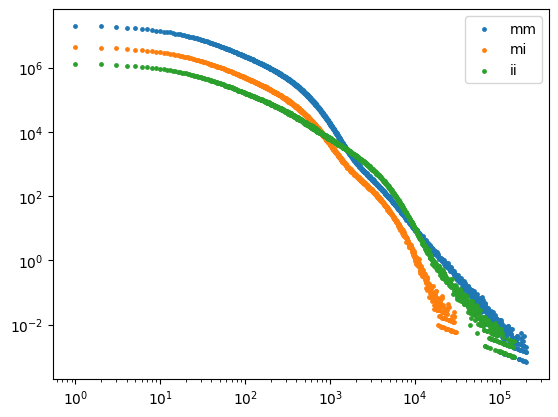

In [6]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(haggmm)
ax.scatter(x, y; s = 6, label="mm")
x, y = xy(haggmi)
ax.scatter(x, y; s = 6, label="mi")
x, y = xy(haggii)
ax.scatter(x, y; s = 6, label="ii")


ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [16]:
fop = FitOptions(Lmm, mu, rho; maxnts=5, g_tol=1e-5, time_limit=120, iterations=30000)
naivemm = pre_fit!(fop, haggmm, 7; require_convergence=false)

7-element Vector{FitResult}:
 Fit stationary (binned 1700) L-BFGS ● [1.1e+11, 24895.3] logL -14226070.729 | evidence -14226096.812
 Fit 2 epochs (binned 1700) L-BFGS ● [1.1e+11, 69700.8, 135552.4, 22162.3] logL -7434517.401 | evidence -7434570.086
 Fit 3 epochs (binned 1700) L-BFGS ● [1.1e+11, 48965.0, 25147.1, 8275.2, 23325.8, 70657.3] logL -45979.816 | evidence -46060.992
 Fit 4 epochs (binned 1700) L-BFGS ● [1.1e+11, 51023.2, 65067.5, 30639.8, 18.9, 10.0, 30144.2, 68320.5] logL -37935.442 | evidence -38043.427
 Fit 5 epochs (binned 1700) L-BFGS ● [1.1e+11, 57277.1, 255761.4, 47002.9, 28526.6, 9071.3, 9209.7, 100000000.0, 11420.8, 63030.7] logL -34646.895 | evidence -34757.939
 Fit 6 epochs (binned 1700) L-BFGS ● [1.1e+11, 59248.1, 293791.4, 47512.2, 30204.4, 9427.1, 10483.6, 99995999.6, 6832.2, 53846.5, 2742.3, 75174.8] logL -33504.206 | evidence -33638.341
 Fit 7 epochs (binned 1700) L-BFGS ● [1.1e+11, 58342.6, 277038.3, 47290.2, 28879.2, 9195.1, 13149.6, 187863.0, 5110.0, 48617.2,

In [14]:
fop = FitOptions(Lmi, mu, rho; maxnts=5, g_tol=1e-5, time_limit=120, iterations=30000)
naivemi = pre_fit!(fop, haggmi, 7; require_convergence=false)

7-element Vector{FitResult}:
 Fit stationary (binned 1700) L-BFGS ● [2.5e+10, 24347.2] logL -2699973.262 | evidence -2699997.829
 Fit 2 epochs (binned 1700) L-BFGS ● [2.5e+10, 66966.8, 126732.8, 21434.9] logL -1027822.963 | evidence -1027872.796
 Fit 3 epochs (binned 1700) L-BFGS ● [2.5e+10, 48617.8, 16053.6, 6089.5, 28828.6, 40935.5] logL -45423.494 | evidence -45500.265
 Fit 4 epochs (binned 1700) L-BFGS ● [2.5e+10, 48369.1, 22.0, 10.0, 34178.2, 36976.8, 1480.6, 100000000.0] logL -34098.806 | evidence -34193.708
 Fit 5 epochs (binned 1700) L-BFGS ● [2.5e+10, 49302.3, 33784.8, 10236.6, 12151.2, 100000000.0, 4778.1, 18160.9, 2887.5, 687729.2] logL -22723.535 | evidence -22831.347
 Fit 6 epochs (binned 1700) L-BFGS ● [2.5e+10, 55257.1, 189718.8, 45164.8, 25233.5, 8602.6, 15303.7, 132030.9, 4114.1, 17677.6, 2898.8, 699530.3] logL -21681.668 | evidence -21817.142
 Fit 7 epochs (binned 1700) L-BFGS ● [2.5e+10, 55192.5, 187850.8, 45093.1, 24896.0, 8531.7, 15740.1, 119573.3, 3726.1, 16622.0,

In [15]:
fop = FitOptions(Lii, mu, rho; maxnts=5, g_tol=1e-5, time_limit=120, iterations=30000)
naiveii = pre_fit!(fop, haggii, 7; require_convergence=false)

7-element Vector{FitResult}:
 Fit stationary (binned 1700) L-BFGS ● [1.6e+10, 14044.2] logL -4840263.520 | evidence -4840287.947
 Fit 2 epochs (binned 1700) L-BFGS ● [2.3e+10, 37335.7, 28052.2, 6410.0] logL -306193.124 | evidence -306245.375
 Fit 3 epochs (binned 1700) L-BFGS ● [2.3e+10, 51534.4, 56910.7, 15206.1, 14776.6, 5693.2] logL -172902.189 | evidence -172979.472
 Fit 4 epochs (binned 1700) L-BFGS ● [2.3e+10, 49483.3, 52967.3, 12160.5, 3138.2, 2075.6, 3042.0, 38288.1] logL -20711.360 | evidence -20815.360
 Fit 5 epochs (binned 1700) L-BFGS ● [2.3e+10, 48938.4, 33306.2, 11070.0, 15305.7, 14228.0, 4083.4, 2431.2, 2863.4, 40233.0] logL -20534.503 | evidence -20658.340
 Fit 6 epochs (binned 1700) L-BFGS ○ [2.3e+10, 54048.7, 266022.2, 46987.7, 20.2, 18.1, 35209.1, 13398.9, 3951.4, 2399.5, 2877.3, 40103.0] logL -20476.879 | evidence -20621.108
 Fit 7 epochs (binned 1700) L-BFGS ● [2.3e+10, 54131.1, 269341.4, 47037.0, 20.1, 18.2, 35430.4, 13342.6, 3852.6, 2360.6, 1510.0, 34336.6, 1409.

In [13]:
compare_models(naiveii)

Fit 3 epochs (binned 1700) L-BFGS ● [2.3e+10, 18931.3, 41795.1, 12424.4, 5057.8, 85876.2] logL -19558.966 | evidence -19633.136

In [15]:
cutoff = 1e-5
o = findfirst(map(i->HetDister.fraction(mu,rho,i),1:30) .< cutoff)

13

In [ ]:
jobs = [
    (edges = haggmm.edges, weights = haggmm.weights, L = Lmm, mu = mu, rho = rho, g=1e-5),
    (edges = haggmi.edges, weights = haggmi.weights, L = Lmi, mu = mu, rho = rho, g=1e-5),
    (edges = haggii.edges, weights = haggii.weights, L = Lii, mu = mu, rho = rho, g=1e-5),
]

In [ ]:
# serialize("jobs", jobs)

In [8]:
cache = SQLiteCache("/project/GHIST-2025/secondary-contact/aggregate-fits-final.cache")

SQLiteCache at /project/GHIST-2025/secondary-contact/aggregate-fits-final.cache

In [9]:
fem = FlexElasticManager(threads = 64, runtime = "6h", memory = "60G") # 165 min

FlexElasticManager: GDW-Mon-1017 active: 0

In [10]:
MariuxUtils.@everywhere fem begin

    using HetDister, StatsBase, Cached

    function fit(job)
        h = Histogram(job.edges)
        h.weights .= job.weights
        fop = FitOptions(job.L, job.mu, job.rho; 
            order = 13, ndt = 1700, maxnts = 5, iterations=30000,
            time_limit=120, g_tol=job.g
        )
        fit = demoinfer(h, 4:6, fop; iters = 40, corcut = 0)
        return fit
    end

end # everywhere

In [11]:
addprocs(fem, MXQ, 3)

FlexElasticManager: GDW-Mon-1017 active: 0  MXQgroup (6h): no active jobs

In [13]:
waituntilactive(fem)

FlexElasticManager: GDW-Mon-1017 active: 3  MXQgroup (6h): inq:0 run:3 fin:0

In [14]:
@async results = pcmap(fit, cache, jobs);

In [31]:
rmprocs(fem)

FlexElasticManager: EPZ-Sun-1141 active: 0, terminated: 3  MXQgroup (3h): inq:0 run:1 fin:2

In [20]:
summary(cache)

"SQLiteCache at /project/GHIST-2025/secondary-contact/aggregate-fits-final.cache: 2 items in memory, 2 items on disk, 2.574 MiB on disk"

In [36]:
Cached.loadall!(cache)
results = values(cache.loaded);

In [29]:
fmm = compare_models(results[1].fits)  # mainland-mainland
fmi = compare_models(results[2].fits)  # mainland-island
fii = compare_models(results[3].fits)  # island-island

Fit 4 epochs (binned 1700) L-BFGS ● [2.3e+10, 17284.0, 38222.4, 13903.2, 10.0, 145.3, 4102.6, 56922.7] logL -19848.979 | evidence -19947.074

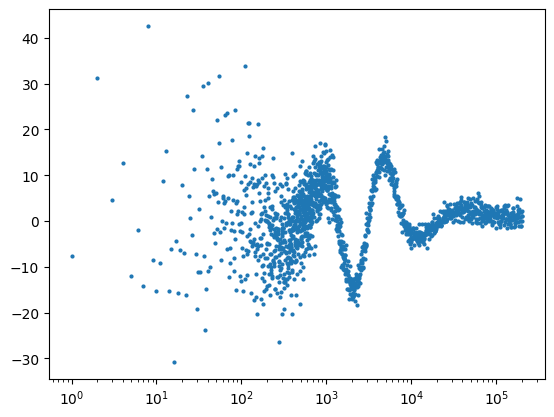

In [60]:
_, ax = subplots(1,1)
# resid = compute_residuals(haggmm, mu, rho, get_para(naivemm[7]), order = 13, ndt = 1700, naive = true)
wth = tmp.yth[4] .* diff(haggmm.edges[1])
resid = (haggmm.weights .- wth) ./ sqrt.(wth)
x, y = xy(haggmm)
scatter(x, resid; s=4)
xscale("log")
# ylim(-3,3)

In [53]:
( 
    fmm.para[end],
    fii.para[end],
    sum(durations(fmi)[end-1:end]),
    durations(fmm)[end],
    1/2fmi.para[end-2] * 2fii.para[end]
)

(18814.66118639864, 56922.71460875922, 3273.2032126028134, 2351.7013235222007, 0.6245382416700742)

In [52]:
sum(durations(fmm)[end-1:end]), sum(durations(fmi)[end-1:end])

(3403.260460962385, 3273.2032126028134)

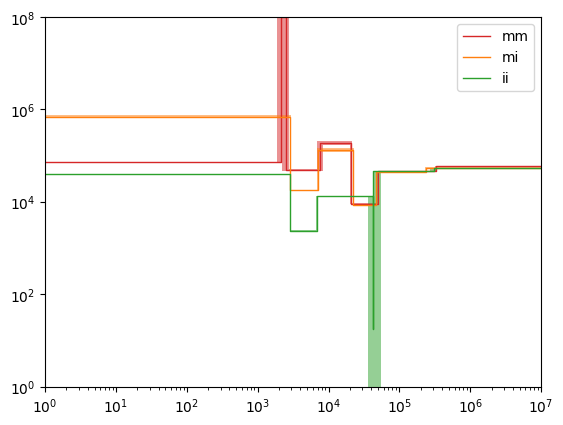

PyObject <matplotlib.legend.Legend object at 0x7eff229df6d0>

In [61]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

plot_demography(naivemm[7], ax; g = 1, rho, label="mm")
plot_demography(naivemi[6], ax; g = 1, rho, label="mi", color="tab:orange")
plot_demography(naiveii[6], ax; g = 1, rho, label="ii", color="tab:green")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 1e7)
ax.set_ylim(1, 1e8)
ax.legend()

## all pairs

In [10]:
segments1 = getsegments(df, :island_1, :mainland_1, 2, 2);
segments2 = getsegments(df, :island_2, :island_3, 2, 2);
segments3 = getsegments(df, :mainland_2, :mainland_3, 2, 2);
h1 = adapt_histogram(segments1; nbins = 800)
h2 = adapt_histogram(segments2; nbins = 800)
h3 = adapt_histogram(segments3; nbins = 800)

Histogram{Int64, 1, Tuple{LogEdgeVector{Int64}}}
edges:
  LogEdgeVector{Int64}: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 20

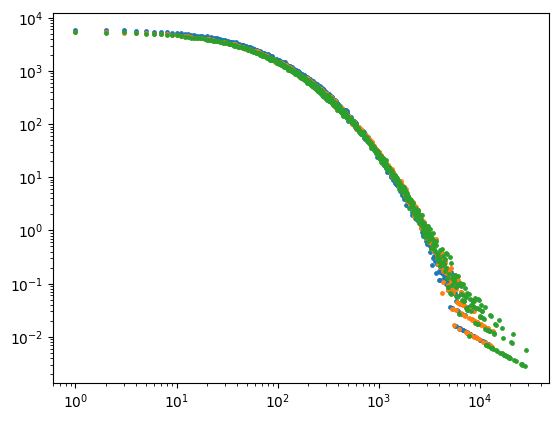

In [11]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(h1)
ax.scatter(x, y; s = 6)
x, y = xy(h2)
ax.scatter(x, y; s = 6)
x, y = xy(h3)
ax.scatter(x, y; s = 6)

ax.set_xscale("log")
ax.set_yscale("log")

In [13]:
histograms_mi = makepairs(df; nsamples1=24, nsamples2=11, name1="mainland_", name2="island_");
histograms_ii = makepairs(df; nsamples1=11, nsamples2=11, name1="island_", name2="island_");
histograms_mm = makepairs(df; nsamples1=24, nsamples2=24, name1="mainland_", name2="mainland_");

In [ ]:
# serialize("histograms_mi", histograms_mi)
# serialize("histograms_ii", histograms_ii)
# serialize("histograms_mm", histograms_mm)
# histograms = deserialize("histograms");

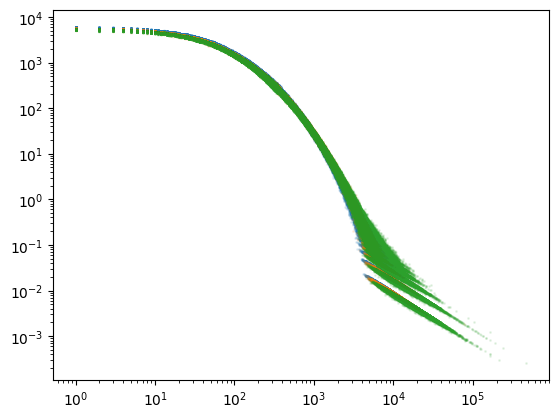

In [15]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

for h in histograms_mi
    x, y = xy(h)
    ax.scatter(x, y; s = 1, alpha = 0.1, color="tab:blue")
end
for h in histograms_ii
    x, y = xy(h)
    ax.scatter(x, y; s = 1, alpha = 0.1, color="tab:orange")
end
for h in histograms_mm
    x, y = xy(h)
    ax.scatter(x, y; s = 1, alpha = 0.1, color="tab:green")
end

ax.set_xscale("log")
ax.set_yscale("log")